# DNN for learning Coulomb Blockade
A simple DNN will be used to learn to *integrate* the current characteristics to find the charge on the device.

In [1]:
import numpy as np
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time

# for better figures
import matplotlib as mpl
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams.update({'font.size': 16})

import matplotlib.cm as cm
mpl.rcParams['font.family'] = "serif"

In [2]:
file_list = glob.glob("/Users/sandesh/data/quantum-ml/data_for_paper/single_dot_low_var/*.npy")
print("Number of files",len(file_list))
data_list = [np.load(f).item() for f in file_list[:]]
print("Data keys",data_list[0].keys())

Number of files 1000
Data keys dict_keys(['V_P_vec', 'type', 'physics', 'output'])


## Sample Current and Charge Traces from the data

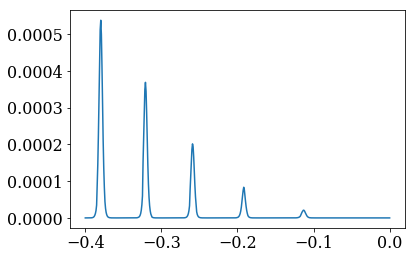

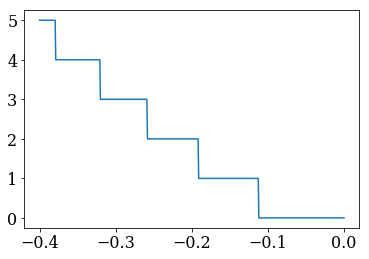

In [3]:
# sample data plots
file_index = np.random.randint(len(data_list))
V_P_vec = data_list[file_index]['V_P_vec']
current_vec = [x['current'] for x in data_list[file_index]['output']]
charge_vec = [np.sum(x['charge']) for x in data_list[file_index]['output']]

plt.figure(1)
plt.plot(V_P_vec,current_vec)

plt.figure(2)
plt.plot(V_P_vec,charge_vec)

## Loading of the data
The data is put into separate input and output lists so that it works with the code of the DNN from tensorflow.

In [4]:
inp_array = []
out_array = []
for dat in data_list:
    inp_array.append(np.array([x['current'] for x in dat['output']]))
    out_array.append(np.array([np.sum(x['charge']) for x in dat['output']]))
inp_array = np.array(inp_array)
out_array = np.array(out_array)

### View of the dataset
I will plot all current and voltage trace to see how part of the dataset looks like.

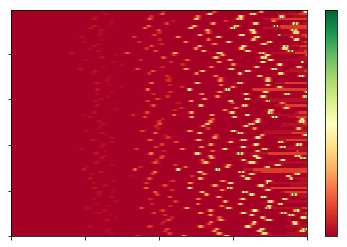

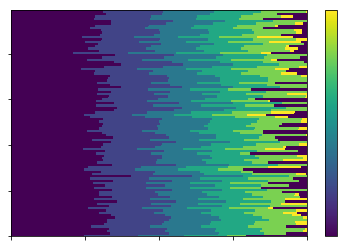

In [6]:
plt.figure(1)
num_samples = 100
V_P_vec = data_list[file_index]['V_P_vec']
XX,YY = np.meshgrid(V_P_vec,range(num_samples))
plt.pcolor(-XX,YY,inp_array[:num_samples]/np.max(inp_array[:num_samples]),cmap=cm.RdYlGn)
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_ticklabels([])
plt.tight_layout()
a = plt.gca()
a.set_xticklabels([])
a.set_yticklabels([])
plt.savefig("/Users/sandesh/Desktop/cb_current_dataset.pdf",dpi=300)

plt.figure(2)
XX,YY = np.meshgrid(V_P_vec,range(num_samples))
plt.pcolor(-XX,YY,out_array[:num_samples])
cbar = plt.colorbar()
cbar.set_ticks([])
cbar.set_ticklabels([])
plt.tight_layout()
a = plt.gca()
a.set_xticklabels([])
a.set_yticklabels([])
plt.savefig("/Users/sandesh/Desktop/cb_charge_dataset.pdf",dpi=300)

## Constructing the DNN Regressor
A packaged DNN is used from the tensorflow.contrib.learn.DNNRegressor API.

In [9]:
import datetime
model_dir_path = "/Users/sandesh/trained_networks/single_dot_" \
                + datetime.datetime.now().strftime("%Y%m%d-%H%M%S%f") + "/" 
import pathlib
pathlib.Path('model_dir_path').mkdir(parents=True, exist_ok=True) 

# determines the number of inputs used as the training set
# the rest are treated as a test set
train_factor = 0.9

n_tot = inp_array.shape[0]
n_train = int(train_factor*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = inp_array[0].shape[0] 
n_out = out_array[0].shape[0] 
print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)

x_train_data = inp_array[:n_train]
y_train_data = out_array[:n_train].astype(int)
x_test_data = inp_array[n_train:]
y_test_data = out_array[n_train:].astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)

def get_train_inputs():
    # load a random batch of batch_size to perform the training
    batch_size = 100
    idx = np.random.randint(n_train,size=batch_size)
    
    batch_in_data = inp_array[idx,:]
    batch_out_data = out_array[idx,:].astype(int)
    x = tf.constant(batch_in_data)
    y = tf.constant(batch_out_data)
    return x,y

def get_test_inputs():
    x = tf.constant(x_test_data)
    y = tf.constant(y_test_data)
    return x,y

# load datasets
features = [tf.contrib.layers.real_valued_column("",dimension=n_inp)]
regressor = tf.contrib.learn.DNNRegressor(feature_columns=features,
                                          label_dimension=n_out,
                                          hidden_units=[1024,256,12],
                                          optimizer=tf.train.AdamOptimizer(),
                                          model_dir = model_dir_path,
                                         )
def accuracy(inp,out):
    predictions = list(regressor.predict(input_fn=lambda : inp))
    def eval_accur(y1,y2):
        diff = np.abs(y1-y2)
        return len(np.where(diff == 0)[0])*1.0/len(diff)
    accur = [eval_accur(x,y) for (x,y) in zip(out,np.rint(predictions))]
    return np.mean(accur)
    


Number of inputs: 512
Number of outputs: 512
Total, Training, Test
1000 900 100


In [ ]:
st = time.time()
for i in range(50):
    print("Steps",i*1000)
    regressor.fit(input_fn=get_train_inputs, steps=1000)
    print("Training Accuracy : ",accuracy(x_train_data,y_train_data))
    print("Test Accuracy : ",accuracy(x_test_data,y_test_data))
print(time.time()-st,"seconds")

## Predict using the trained DNN
The accuracy for each sample is calculated as the number of points in the voltage space where it correctly predicts the charges. The total accuracy is defined as the mean over all the samples in the test set.

In [10]:
model_dir_path = "/Users/sandesh/trained_networks/single_dot_20171129-123325974865"
# load datasets
features = [tf.contrib.layers.real_valued_column("",dimension=n_inp)]
regressor = tf.contrib.learn.DNNRegressor(feature_columns=features,
                                          label_dimension=n_out,
                                          hidden_units=[1024,256,12],
                                          optimizer=tf.train.AdamOptimizer(),
                                          model_dir = model_dir_path,
                                         )

In [ ]:

predictions = list(regressor.predict(input_fn=get_test_inputs))
def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
print("Test Accuracy : ",np.mean(accur))

In [ ]:
predictions = list(regressor.predict(input_fn=lambda : x_train_data))
def eval_accur(y1,y2):
    diff = np.abs(y1-y2)
    return len(np.where(diff == 0)[0])*1.0/len(diff)
accur = [eval_accur(x,y) for (x,y) in zip(y_train_data[:],np.rint(predictions))]
print("Training Accuracy : ",np.mean(accur))

## Sample Predictions
A random sample from the test set is picked and the output from the DNN is compared with the actual expected output as a visualisation.

In [7]:
index = np.random.randint(n_test)
index = 8
plt.figure(1)
plt.plot(-V_P_vec,x_test_data[index]/np.max(x_test_data[index]),'b',linewidth=3.0,label="Current")
plt.legend(loc=(0.04,0.7))
plt.tight_layout()
a = plt.gca()
a.set_xticklabels([])
a.set_yticklabels([])
plt.savefig("/Users/sandesh/Desktop/cb_current_sample.pdf",dpi=300)

plt.figure(2)
plt.plot(-V_P_vec,np.rint(predictions[index]),'orange',label="Prediction",linewidth=3.0)
plt.plot(-V_P_vec,y_test_data[index],color="darkviolet",linestyle="--",label="Actual",linewidth=3.0)
plt.legend(loc=(0.04,0.5))
plt.tight_layout()
a = plt.gca()
a.set_xticklabels([])
a.set_yticklabels([])
plt.savefig("/Users/sandesh/Desktop/cb_charge_sample.pdf",dpi=300)

NameError: name 'n_test' is not defined

In [106]:
index

8